# Data exploratory on 2015 World Teams Championship

1. [Import data](#import)  
    1.1 [Prepare for import data](#import)  
    1.2 [Download data](#download)  
    
    
2. [Clean data](#clean)  
    2.1 [Extract](#clean)  
    2.2 [Split data to dataframs](#split)  
    2.3 [Data first view](#check)  
    2.4 [Join dataframe](#join)  
    2.5 [Split bid to columns](#bid)  
    2.6 [Create useful columns](#HCP)  
    
    - 2.6.1 [HCP columns](#HCP)  
    - 2.6.2 [Game Type column](#type)  
    - 2.6.3 [Declar HCP](#d_HCP)  
    - 2.6.4 [Trump fit](#fit)  
    
  2.7 [Cleaned data view](#cleaned)  


3. [Data exploratory](#exploratory)  
    [Q1. How many Game, Slam, Partial were played and made?](#q1)  
    [Q2. How many different Games were played?](#q2)  
    [Q3. Is game made percent different between Vul?](#q3)  
    [Q4. Is game made percent different between game type?](#q4)  
    [Q5. How many HCP to make game?](#q5)  
    [Q6. How many HCP & fit to make over 10 tricks in a suits game?](#q6)  
    [Q7. Is 8 fit, 25HCP a good strategy to make 10 trick in suits contract?](#q7)  
    [Q8. Is free run easier to make compare with opponent interrupt?](#q8)  
    [Q9. Calcurate Expected Value of pass/bid in game?](#q9)  

## 1. Import data
<a id="import"></a>

### 1.1 Prepare for import data

In [1]:
# runtime check
import time
start_time = time.time()

# import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor

In [2]:
# Prepare for download the data

# Specify url of 2015 World Teams Championship
url = 'http://www.sarantakos.com/bridge/vugraph/2015/2015-wbc.html'

# Package the request, send the request and catch the response: r
r = requests.get(url)
 
# Extracts the response as html: html_doc
html_doc = r.text
 
# create a BeautifulSoup object from the HTML: soup
soup = BeautifulSoup(html_doc)

# Find all 'a' tags (which define hyperlinks): a_tags
a_tags = soup.find_all('a')

# Initialize a list to store the lin file list 
# lin file is a bridge hand file can be read into BBO
url_list = []

# get urls from a_tags
for link in a_tags:
    url_list.append(link.get('href'))

# If file not end with ''.lin', then remove it from the original list
# Add full path to the file
fullpath = 'http://www.sarantakos.com/bridge/vugraph/2015/'
url_list = [fullpath + linfile for linfile in url_list if bool(re.search('\.lin$', str(linfile)))]

### 1.2 Download data
<a id="download"></a>

In [3]:
# Download the files from url_list and store them into row data
row_data = []

for url in url_list:
    row_data.append(requests.get(url).text)


## 2. Clean data
<a id="clean"></a>

### 2.1 Extract

In [4]:
# Use regular expression to extract the rows we are interested
p1 = 'qx.*\|p\|mb\|p\|mb\|p\|' # Hands and biddings
p2 = 'vg\|.*\|' # Name of the match
p3 = 'rs\|.*\|' # Results
p4 = 'pn\|.*\|' # Players
pattern1 = re.compile("(%s|%s|%s|%s)" % (p1, p2, p3, p4))

# Initialize a list to store the data we are interested in
data_of_interested = []

for data in row_data:
    data_of_interested.append(re.findall(pattern1, data))

In [5]:
# Use regular expression to replace unmeaningful words 1

# Initialize a list to store the data with this replace = clean
clean1_data = []
clean2_data = []
clean3_data = []
clean4_data = []
clean5_data = []

# The patterns
p5 = 'qx\|'
p6 = 'st\|\|md\|'
p7 = 'sv\|'
p8 = 'mb\|'
p9 = 'vg\|'
p10 = 'rs\|'
p11 = 'pn\|'
p12 = '\|pg\|\|'
p13 = '!'
p14 = '\|$'
pattern2 = re.compile("(%s|%s|%s|%s|%s|%s|%s|%s|%s|%s)" % (p5, p6, p7, p8, p9, p10, p11, p12, p13, p14))

# Replace pattern2 to ''
for i, data in enumerate(data_of_interested):
    clean1_data.append([re.sub(pattern2, '', x) for x in data_of_interested[i]])

# Replace the first 3 '|' to ','
for i, data in enumerate(clean1_data):
    clean2_data.append([re.sub('\|', ',', x, 3) for x in clean1_data[i]])

# Replace the rest  '|' with ''
for i, data in enumerate(clean2_data):
    clean3_data.append([re.sub('\|', '', x) for x in clean2_data[i]])
    
# Add a comma between 3 and S in 'o1,3S'
for i, data in enumerate(clean3_data):
    clean4_data.append([re.sub(r'([oc]\d*,\d)', r'\1,', x, 1) for x in clean3_data[i]])

# Add id for each file in clean4_data
for i, data in enumerate(clean4_data):
    clean5_data.append([re.sub(r'^', str(i)+',', x) for x in clean4_data[i]])

### 2.2 Split data to dataframs
<a id="split"></a>

In [6]:
# Split data into 3 parts
# Part 1: All rows expect row1 and row3, this is the play data
bid_data = [row[1:2] for row in clean5_data]
game_data = [row[3:] for row in clean5_data]

# Part 2: row1, game meta-info
info_data = [row[0:1] for row in clean5_data]

# Part 3: row3, player name
player_data = [row[2:3] for row in clean5_data]

In [7]:
# Unpack 2D list to 1D list
info_data = [row for lists in info_data for row in lists]
bid_data = [row for lists in bid_data for row in lists]
player_data = [row for lists in player_data for row in lists]
game_data = [row for lists in game_data for row in lists]

In [8]:
# Create df for each data
info_data_df = pd.DataFrame([line.split(",") for line in info_data])
bid_data_df = pd.DataFrame([line.split(",") for line in bid_data])
player_data_df = pd.DataFrame([line.split(",") for line in player_data])
game_data_df = pd.DataFrame([line.split(",") for line in game_data])

### 2.3 Data first view
<a id="check"></a>

In [9]:
# Add column name
info_data_df.columns = ['match_id', 'match_name', 'session', 'session_No',
                        'start_board', 'end_board', 'Team1', 'Team1_score',
                        'Team2', 'Team2_score']

# Get an idea of what the df look like
info_data_df.head()

,match_id,match_name,session,session_No,start_board,end_board,Team1,Team1_score,Team2,Team2_score
0,0,BBO6-2015WBTC-BB,RR1,I,1,16,CHINA,0,FRANCE,0
1,1,BBO3-2015 WBTC-BB,RR1,I,1,16,DENMARK,0,USA-2,0
2,2,BBO4-2015WBTC-BB,RR1,I,1,16,EGYPT,0,AUSTRALIA,0
3,3,BBO1-2015WBTC-BB,RR1,I,1,16,ENGLAND,0,INDIA,0
4,4,BBO2-2015WBTC-BB,RR1,I,1,16,USA-1,0,ARGENTINA,0


In [10]:
# Get an idea of what the df look like
bid_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0,4HE-1,4HE-1,4HS+2,6HS=,3NN+3,3NS+1,3NW+1,3NE+1,4HW+1,...,4SN-1,4SN-2,2HE+1,2HE+2,1NE+2,3NE+1,3HS=,2HS+1,3NE-2,3NEx-2
1,1,3NE-2,4HE-1,6HS=,4HS+2,3NN+1,3NS+1,3NW+1,3NE=,4HE+1,...,4SN-1,4SN-2,2HE+1,2HE+1,3NE-1,3NE=,2HS+1,3DWx-3,3DE=,1NE+1
2,2,3NE-2,4HW-1,4HS+2,4HS+2,3NN+2,3NN-1,3NW+1,3NW+1,4HE+1,...,4SN-2,4SN-1,1SE+1,2DE+1,3NE=,3NE+1,3HS=,2SE-3,1NE+2,3NE-1
3,3,4HE-1,4HE=,6HS=,6HS=,3NN+2,3NS+1,3NW=,3NW+2,4HW+2,...,4SS-1,4SN-1,2HE+1,2HE=,3NE+1,3NE+1,2HS+1,3HS-1,1NE+2,3NE+1
4,4,3NE-2,3NE=,6HN+1,4HS+2,3NS+1,3NS+2,3NW+1,3NW=,4HW+1,...,4SN=,4SN-1,2HE+2,2HE+2,3NE-3,3NE+1,3HS+1,2HS=,3NE-1,3NE+1


In [11]:
# Add column name
player_data_df.columns = ['match_id', 
                          'Player1', 'Player2', 'Player3', 'Player4',
                          'Player5', 'Player6', 'Player7', 'Player8']
# Get an idea of what the df look like
player_data_df.head()

,match_id,Player1,Player2,Player3,Player4,Player5,Player6,Player7,Player8
0,0,HU,COMBESCURE,LI,ROMBAUT,VOLCKER,SUN,BESSIS,KANG
1,1,CHRISTIANS,DEMUY,SCHALTZ,KRANYAK,WOOLDRIDGE,ASKGAARD,HURD,KONOW
2,2,RAMADAN,COURTNEY,NOSHY,WYER,GRIFFITHS,SADEK,MILNE,NABIL
3,3,HACKETT,ROY,HACKETT,BANERJEE,MANNA,ROBSON,MAJUMDER,FORRESTER
4,4,KATZ,PELLEGRINI,NICKELL,GARCIA DA,CAMBEROS,RODWELL,MUZZIO,MECKSTROTH


In [12]:
# Add column name
game_data_df.columns = ['match_id', 'Room_Board', 'Hand_index',
                          'Hand1', 'Hand2', 'Hand3', 'Hand4',
                          'Vul', 'bid', 'problem']
                          
# Get an idea of what the df look like
game_data_df.head()

,match_id,Room_Board,Hand_index,Hand1,Hand2,Hand3,Hand4,Vul,bid,problem
0,0,o1,3,SQ72H6D654CKT7654,S985HAQ93DJT7C983,SKJT6HK875D832CQ2,SA43HJT42DAKQ9CAJ,o,p2Np3Cp3Hp4Hppp,None
1,0,c1,3,SQ72H6D654CKT7654,S985HAQ93DJT7C983,SKJT6HK875D832CQ2,SA43HJT42DAKQ9CAJ,o,p2Np3Cp3Hp4Hppp,None
2,0,o2,4,SQ765HAK8DKQT6CJ9,SJ9832HQTDJ72C652,SA4HJ76542DA8CAQ4,SKTH93D9543CKT873,n,p1Np2Dp2Hp2Sp2Np3Hp4Dp4Hppp,None
3,0,c2,4,SQ765HAK8DKQT6CJ9,SJ9832HQTDJ72C652,SA4HJ76542DA8CAQ4,SKTH93D9543CKT873,n,p1Np3Dp3Hp3Sp4Dp4Sp5Dp6Hppp,None
4,0,o3,1,SJ74HQJT64D5CQT42,SK6H8532D98632C93,SAQ95H9DAKQ74CAK8,ST832HAK7DJTCJ765,e,2Hp2Np3Cp3Nppp,None


### 2.4 Join dataframe
<a id="join"></a>

In [13]:
# All data is loaded into a data frame
# Next Step:
# Checking and preprocessing data

In [14]:
# Only 5 data in the last column, use np.nan to replace the unvalid 5 bids
game_data_df.loc[~game_data_df['problem'].isnull(), 'bid'] = np.nan

# Drop the problem column
game_data_df = game_data_df.drop(columns=['problem'])

# Drop the problem rows
game_data_df = game_data_df.drop(index=game_data_df.loc[game_data_df['Hand3'].isnull()].index)

In [15]:
# Set a key to combine with bid data
# Key is match_id + Room_Board
join_key = game_data_df['match_id'] + game_data_df['Room_Board']

game_data_df['join_key'] = join_key

In [16]:
# Transform bid data into one column then sort value
bid_data_df[0] = bid_data_df[0].astype('int')
bid_data_df2 = bid_data_df.melt(id_vars =0).sort_values([0, 'variable'], ascending=[True, True])

# Set a key to combine with game data
bid_data_df2['Room_Board'] = list(game_data_df['Room_Board'][:32]) * bid_data_df.shape[0]

# Set a key to combine with game data
# Key is match_id + Room_Board
bid_data_df2[0] = bid_data_df2[0].astype('str')
join_key2 = bid_data_df2[0] + bid_data_df2['Room_Board']

bid_data_df2['join_key'] = join_key2

In [17]:
# Did data innerjoin game data on join_key
df = pd.merge(game_data_df, bid_data_df2, on=['join_key'], how='inner')

In [18]:
df.head()

,match_id,Room_Board_x,Hand_index,Hand1,Hand2,Hand3,Hand4,Vul,bid,join_key,0,variable,value,Room_Board_y
0,0,o1,3,SQ72H6D654CKT7654,S985HAQ93DJT7C983,SKJT6HK875D832CQ2,SA43HJT42DAKQ9CAJ,o,p2Np3Cp3Hp4Hppp,0o1,0,1,4HE-1,o1
1,0,c1,3,SQ72H6D654CKT7654,S985HAQ93DJT7C983,SKJT6HK875D832CQ2,SA43HJT42DAKQ9CAJ,o,p2Np3Cp3Hp4Hppp,0c1,0,2,4HE-1,c1
2,0,o2,4,SQ765HAK8DKQT6CJ9,SJ9832HQTDJ72C652,SA4HJ76542DA8CAQ4,SKTH93D9543CKT873,n,p1Np2Dp2Hp2Sp2Np3Hp4Dp4Hppp,0o2,0,3,4HS+2,o2
3,0,c2,4,SQ765HAK8DKQT6CJ9,SJ9832HQTDJ72C652,SA4HJ76542DA8CAQ4,SKTH93D9543CKT873,n,p1Np3Dp3Hp3Sp4Dp4Sp5Dp6Hppp,0c2,0,4,6HS=,c2
4,0,o3,1,SJ74HQJT64D5CQT42,SK6H8532D98632C93,SAQ95H9DAKQ74CAK8,ST832HAK7DJTCJ765,e,2Hp2Np3Cp3Nppp,0o3,0,5,3NN+3,o3


In [19]:
# drop useless columns
df.drop(columns=['join_key', 0, 'variable', 'Room_Board_y', 'Hand_index'], inplace=True)

### 2.5 Split bid to columns
<a id="bid"></a>

In [20]:
# from value column, extract contract, doubled, redoubled, playby, result
df['contract'] = df['value'].str.extract('(^\d[NSHDC]|PASS)', expand=True)
df['doubled'] = df['value'].str.extract('(x{1})', expand=True) # redoubled also included
df['redoubled'] = df['value'].str.extract('(x{2})', expand=True)
df['playby'] = df['value'].str.extract('((?<=^.{2}).)', expand=True) # the 3rd letter in value
df['result'] = df['value'].str.extract('([+=-]\d*)', expand=True)

# Drop useless column
df = df.drop(columns=['value'])

In [21]:
# Replace redoubled's x in doubled column with ''
df.loc[~df['redoubled'].isnull(), ['doubled']] = ''

# Replace Null with ''
df.loc[df['doubled'].isnull(), 'doubled'] = ''
df.loc[df['redoubled'].isnull(), 'redoubled'] = ''

# Get a contract with double and redouble
df['contract'] = df['contract'] + df['doubled'] + df['redoubled']

# Replace '' with False and x to True
df.loc[~(df['doubled'] == ''), 'doubled']  = True
df.loc[(df['doubled'] == ''), 'doubled']  = False

df.loc[~(df['redoubled'] == ''), 'redoubled']  = True
df.loc[(df['redoubled'] == ''), 'redoubled']  = False

In [22]:
# Rename the columns
df.columns = ['Match_id', 'Room_BoardNo', 'South', 'West', 'North', 'East', 'Vul',
       'Bid_sequence', 'Contract', 'is_Doubled', 'is_Redoubled', 'Declear', 'Result']

In [23]:
# Convert Result to integer, fillna (PASS) with 0
df.loc[df.Result == '=', 'Result'] = 0
df['Result'] = df['Result'].fillna(0)

In [24]:
# Modify Vul column
dic = {'o':'NONE', 'n':'NS', 'e':'EW', 'b':'BOTH'}
for key, value in dic.items():
    df.loc[df['Vul'] == key, 'Vul'] = value

### 2.6 Create useful columns
<a id="HCP"></a>

#### 2.6.1 HCP columns

In [25]:
# Calculate the value in each hands
HCP = {'A':4, 'K':3, 'Q':2, 'J':1}

south_HCP = []
for lists in list(df['South'].str.findall('[AKQJ]')):
    south_HCP.append([HCP.get(item,item)  for item in lists])

west_HCP = []
for lists in list(df['West'].str.findall('[AKQJ]')):
    west_HCP.append([HCP.get(item,item)  for item in lists])
    
north_HCP = []
for lists in list(df['North'].str.findall('[AKQJ]')):
    north_HCP.append([HCP.get(item,item)  for item in lists])
    
east_HCP = []
for lists in list(df['East'].str.findall('[AKQJ]')):
    east_HCP.append([HCP.get(item,item)  for item in lists])
    
# Sum of the list, turn 2d list into 1d, then change it back to df
south_HCP = pd.DataFrame([sum(x) for x in south_HCP], columns = ['South_HCP'])
west_HCP = pd.DataFrame([sum(x) for x in west_HCP], columns = ['West_HCP'])
north_HCP = pd.DataFrame([sum(x) for x in north_HCP], columns = ['North_HCP'])
east_HCP = pd.DataFrame([sum(x) for x in east_HCP], columns = ['East_HCP'])

In [26]:
# concat all the dataframe to df
df = pd.concat([df, south_HCP, west_HCP, north_HCP, east_HCP], axis=1)

In [27]:
# drop rows which don't have hand records
index = df[(df.South_HCP + df.North_HCP + df.West_HCP + df.East_HCP) == 0].index
df.drop(index=index, inplace=True)

In [28]:
# Add NS HCP and EW HCP
df['NS_HCP'] = df['North_HCP'] + df['South_HCP']
df['EW_HCP'] = df['East_HCP'] + df['West_HCP']

#### 2.6.2 Game Type column
<a id="type"></a>

In [29]:
# Add Game Type: Grand Slam, Small Slam, Game, Partial

# Create all contract
all_contract = []
suits = ('C', 'D', 'H', 'S', 'N')

for i in range(1,8):
    for suit in suits:
        all_contract.append(str(i)+suit)

# Create all type of contract
GSlam = all_contract[-5:]
SSlam = all_contract[-10:-5]
Game = ['3N', '4H', '4S', '4N'] + all_contract[-15:-10]
Partial = all_contract[:14] + ['4C', '4D']

# Store the result of game type
Game_type = []

contracts = df['Contract'].str.extract('(..)')
contracts = list(contracts[0])

for contract in contracts:
    if contract in GSlam:
        Game_type.append('Grand Slam')
    elif contract in SSlam:
        Game_type.append('Small Slam')
    elif contract in Game:
        Game_type.append('Game')
    elif contract in Partial:
        Game_type.append('Partial')
    elif contract == 'PA':
        Game_type.append('PASS')
    else:
        Game_type.append(np.nan)

# change list to a dataframe
Game_type = pd.DataFrame(Game_type, columns=['Game_type'], index=df.index)

# Concate Game_type to df
df = pd.concat([df, Game_type], axis=1)

In [30]:
# Add Trick Taken
df['Offense_Trick_taken'] = df['Contract'].str.extract('(^\d)', expand=True)
df['Offense_Trick_taken'] = df['Offense_Trick_taken'].fillna(0)
df['Offense_Trick_taken'] = df['Offense_Trick_taken'].astype('int')
df['Result'] = df['Result'].fillna(0).astype('int')
df['Offense_Trick_taken'] = df['Offense_Trick_taken'] + df['Result'] + 6

df['Defence_Trick_taken'] = 13 - df['Offense_Trick_taken']

# Add Max_HCP, Max_Trick for either pair
df['Max_HCP'] = np.where(df['EW_HCP'] > df['NS_HCP'], df['EW_HCP'], df['NS_HCP'])
df['Max_Trick'] = np.where(df['Offense_Trick_taken'] > df['Defence_Trick_taken'], df['Offense_Trick_taken'], df['Defence_Trick_taken'])

#### 2.6.3 Declar HCP
<a id="d_HCP"></a>

In [31]:
# Add Declar HCP

Declar_HCP = []

declears = df['Declear'].reindex(df.index)

for i, declear in declears.iteritems():

    is_ns = re.match('[NS]',declear)
    is_ew = re.match('[EW]',declear)
    
    if is_ns:
        NS_HCP = df['North_HCP'][i] + df['South_HCP'][i]
        Declar_HCP.append(NS_HCP)
    elif is_ew:
        EW_HCP = df['East_HCP'][i] + df['West_HCP'][i]
        Declar_HCP.append(EW_HCP)

# change list to a dataframe
Declar_HCP = pd.DataFrame(Declar_HCP, columns=['Declar_HCP'], index=df.index)

# Concate Game_type to df
df = pd.concat([df, Declar_HCP], axis=1)

In [32]:
# Drop NA rows
drop_index = df[df['Match_id'].isnull()].index
df = df.drop(index=drop_index)

In [33]:
# reset the index
df = df.reset_index()

In [34]:
# Modify column types
int_list = ['Match_id', 'Result','South_HCP', 'West_HCP', 'North_HCP', 'East_HCP', 'NS_HCP',
       'EW_HCP', 'Offense_Trick_taken', 'Defence_Trick_taken', 'Max_HCP', 'Max_Trick']

bool_list = ['is_Doubled', 'is_Redoubled']

df[int_list] = df[int_list].applymap(np.int64)
df[bool_list] = df[bool_list].applymap(np.bool)


df['Vul'] = df['Vul'].astype('category')
df['Declear'] = df['Declear'].astype('category')
df['Game_type'] = df['Game_type'].astype('category')

#### 2.6.4 Trump fit
<a id="fit"></a>

In [35]:
# Add trump fit

# Store the result of trump fit
Trump_fit = []

club_contract = df['Contract'].str.contains('C')
diamond_contract = df['Contract'].str.contains('D')
heart_contract = df['Contract'].str.contains('H')
spade_contract = df['Contract'].str.contains('S')
notrump_contract = df['Contract'].str.contains('N')

declears = df['Declear'].tolist()

for i, declear in enumerate(declears):
    if declear in ['N', 'S']:
        if club_contract[i]:
            n_c_index = df['North'][i].find('C')
            s_c_index = df['South'][i].find('C')
            c_len = len(df['North'][i][n_c_index+1:]) + len(df['South'][i][s_c_index+1:])
            Trump_fit.append(c_len)
        elif diamond_contract[i]:
            n_c_index = df['North'][i].find('C')
            s_c_index = df['South'][i].find('C')
            n_d_index = df['North'][i].find('D')
            s_d_index = df['South'][i].find('D')
            d_len = len(df['North'][i][n_d_index+1:n_c_index]) + len(df['South'][i][s_d_index+1:s_c_index])
            Trump_fit.append(d_len)
        elif heart_contract[i]:
            n_d_index = df['North'][i].find('D')
            s_d_index = df['South'][i].find('D')
            n_h_index = df['North'][i].find('H')
            s_h_index = df['South'][i].find('H')
            h_len = len(df['North'][i][n_h_index+1:n_d_index]) + len(df['South'][i][s_h_index+1:s_d_index])
            Trump_fit.append(h_len)
        elif spade_contract[i]:
            n_h_index = df['North'][i].find('H')
            s_h_index = df['South'][i].find('H')
            n_s_index = df['North'][i].find('S')
            s_s_index = df['South'][i].find('S')
            s_len = len(df['North'][i][n_s_index+1:n_h_index]) + len(df['South'][i][s_s_index+1:s_h_index])
            Trump_fit.append(s_len)
        else:
            Trump_fit.append(0)
    elif declear in ['E', 'W']:
        if club_contract[i]:
            n_c_index = df['East'][i].find('C')
            s_c_index = df['West'][i].find('C')
            c_len = len(df['East'][i][n_c_index+1:]) + len(df['West'][i][s_c_index+1:])
            Trump_fit.append(c_len)
        elif diamond_contract[i]:
            n_c_index = df['East'][i].find('C')
            s_c_index = df['West'][i].find('C')
            n_d_index = df['East'][i].find('D')
            s_d_index = df['West'][i].find('D')
            d_len = len(df['East'][i][n_d_index+1:n_c_index]) + len(df['West'][i][s_d_index+1:s_c_index])
            Trump_fit.append(d_len)
        elif heart_contract[i]:
            n_d_index = df['East'][i].find('D')
            s_d_index = df['West'][i].find('D')
            n_h_index = df['East'][i].find('H')
            s_h_index = df['West'][i].find('H')
            h_len = len(df['East'][i][n_h_index+1:n_d_index]) + len(df['West'][i][s_h_index+1:s_d_index])
            Trump_fit.append(h_len)
        elif spade_contract[i]:
            n_h_index = df['East'][i].find('H')
            s_h_index = df['West'][i].find('H')            
            n_s_index = df['East'][i].find('S')
            s_s_index = df['West'][i].find('S')
            s_len = len(df['East'][i][n_s_index+1:n_h_index]) + len(df['West'][i][s_s_index+1:s_h_index])
            Trump_fit.append(s_len)
        else:
            Trump_fit.append(0)
    else:
        print('ELSE')

# change list to a dataframe
Trump_fit = pd.DataFrame(Trump_fit, columns=['Trump_fit'], index=df.index, dtype='int64')

# Concate Gtrump fit to df
df = pd.concat([df, Trump_fit], axis=1)

### 2.7 Cleaned data view
<a id="cleaned"></a>

In [36]:
df.head()

,index,Match_id,Room_BoardNo,South,West,North,East,Vul,Bid_sequence,Contract,...,East_HCP,NS_HCP,EW_HCP,Game_type,Offense_Trick_taken,Defence_Trick_taken,Max_HCP,Max_Trick,Declar_HCP,Trump_fit
0,0,0,o1,SQ72H6D654CKT7654,S985HAQ93DJT7C983,SKJT6HK875D832CQ2,SA43HJT42DAKQ9CAJ,NONE,p2Np3Cp3Hp4Hppp,4H,...,19,14,26,Game,9,4,26,9,26,8
1,1,0,c1,SQ72H6D654CKT7654,S985HAQ93DJT7C983,SKJT6HK875D832CQ2,SA43HJT42DAKQ9CAJ,NONE,p2Np3Cp3Hp4Hppp,4H,...,19,14,26,Game,9,4,26,9,26,8
2,2,0,o2,SQ765HAK8DKQT6CJ9,SJ9832HQTDJ72C652,SA4HJ76542DA8CAQ4,SKTH93D9543CKT873,NS,p1Np2Dp2Hp2Sp2Np3Hp4Dp4Hppp,4H,...,6,30,10,Game,12,1,30,12,30,9
3,3,0,c2,SQ765HAK8DKQT6CJ9,SJ9832HQTDJ72C652,SA4HJ76542DA8CAQ4,SKTH93D9543CKT873,NS,p1Np3Dp3Hp3Sp4Dp4Sp5Dp6Hppp,6H,...,6,30,10,Small Slam,12,1,30,12,30,9
4,4,0,o3,SJ74HQJT64D5CQT42,SK6H8532D98632C93,SAQ95H9DAKQ74CAK8,ST832HAK7DJTCJ765,EW,2Hp2Np3Cp3Nppp,3N,...,9,28,12,Game,12,1,28,12,28,0


## 3. Data exploratory
<a id="exploratory"></a>

### Q1. How many Game, Slam, Partial were played and made?
<a id="q1"></a>

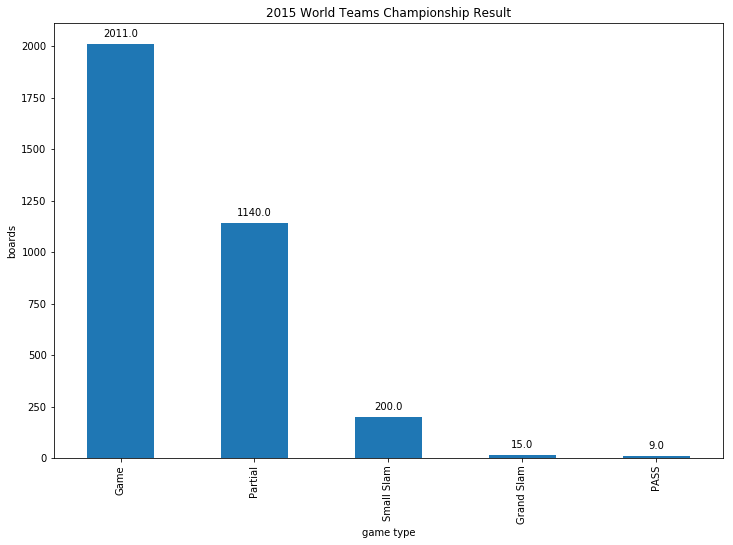

In [37]:
# code from https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
# Bring some raw data.
frequencies = df['Game_type'].value_counts()

# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
freq_series = pd.Series(frequencies)

x_labels = df['Game_type'].value_counts().index

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('2015 World Teams Championship Result')
ax.set_xlabel('game type')
ax.set_ylabel('boards')
ax.set_xticklabels(x_labels)


def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)

In [38]:
# How many boards are made?

overall_made = np.sum(df['Result'] >= 0)
overall_down = np.sum(df['Result'] < 0)
overall_made_percent = overall_made / (overall_made + overall_down)

partial_made = np.sum(np.logical_and(df['Game_type'] == 'Partial', df['Result'] >= 0))
partial_down = np.sum(np.logical_and(df['Game_type'] == 'Partial', df['Result'] < 0))
partial_made_percent = partial_made / (partial_made + partial_down)

game_made = np.sum(np.logical_and(df['Game_type'] == 'Game', df['Result'] >= 0))
game_down = np.sum(np.logical_and(df['Game_type'] == 'Game', df['Result'] < 0))
game_made_percent = game_made / (game_made + game_down)

sslam_made = np.sum(np.logical_and(df['Game_type'] == 'Small Slam', df['Result'] >= 0))
sslam_down = np.sum(np.logical_and(df['Game_type'] == 'Small Slam', df['Result'] < 0))
sslam_made_percent = sslam_made / (sslam_made + sslam_down)

gslam_made = np.sum(np.logical_and(df['Game_type'] == 'Grand Slam', df['Result'] >= 0))
gslam_down = np.sum(np.logical_and(df['Game_type'] == 'Grand Slam', df['Result'] < 0))
gslam_made_percent = gslam_made / (gslam_made + gslam_down)

print('overall made: {}'.format(overall_made))
print('overall down: {}'.format(overall_down))
print('overall made percent: {}'.format(overall_made_percent))
print('---------------------------------')
print('partial made: {}'.format(partial_made))
print('partial down: {}'.format(partial_down))
print('partial made percent: {}'.format(partial_made_percent))
print('---------------------------------')
print('game made: {}'.format(game_made))
print('game down: {}'.format(game_down))
print('game made percent: {}'.format(game_made_percent))
print('---------------------------------')
print('small slam made: {}'.format(sslam_made))
print('small slam down: {}'.format(sslam_down))
print('small slam made percent: {}'.format(sslam_made_percent))
print('---------------------------------')
print('grand slam made: {}'.format(gslam_made))
print('grand slam down: {}'.format(gslam_down))
print('grand slam made percent: {}'.format(gslam_made_percent))

overall made: 2167
overall down: 1208
overall made percent: 0.642074074074074
---------------------------------
partial made: 690
partial down: 450
partial made percent: 0.6052631578947368
---------------------------------
game made: 1338
game down: 673
game made percent: 0.6653406265539532
---------------------------------
small slam made: 123
small slam down: 77
small slam made percent: 0.615
---------------------------------
grand slam made: 7
grand slam down: 8
grand slam made percent: 0.4666666666666667


### Q2. How many different Games were played?
<a id="q2"></a>

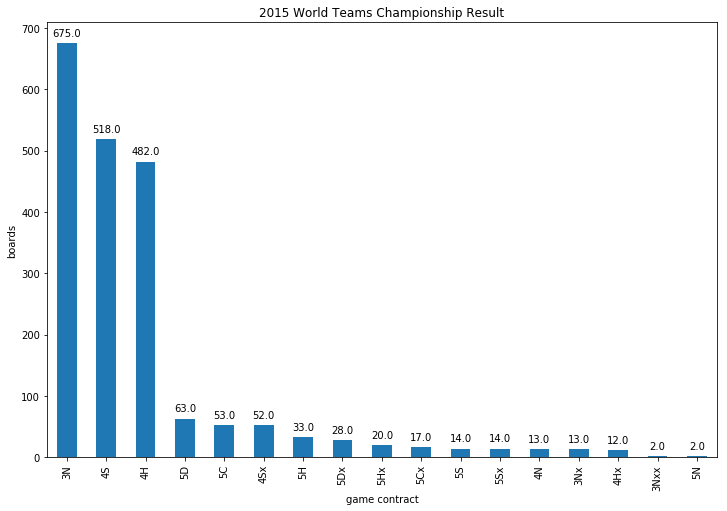

In [39]:
# code from https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
# Bring some raw data.
frequencies = df.loc[df['Game_type'] == 'Game', 'Contract'].value_counts()

# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
freq_series = pd.Series(frequencies)

x_labels = df.loc[df['Game_type'] == 'Game', 'Contract'].value_counts().index

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('2015 World Teams Championship Result')
ax.set_xlabel('game contract')
ax.set_ylabel('boards')
ax.set_xticklabels(x_labels)


def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)

### Q3. Is game made percent different between Vul?
<a id="q3"></a>

In [40]:
# Is game made percent different between Vul?

c1 = df['Game_type'] == 'Game'
c2 = df['Result'] >= 0
c3 = df['Result'] < 0
c4 = df['Vul'] == 'NONE'
c5 = df['Vul'] == 'BOTH'
# We Vul
c6 = np.logical_or(np.logical_and(df['Declear'].str.match('[NS]'), df['Vul'] == 'NS'), 
                   np.logical_and(df['Declear'].str.match('[EW]'), df['Vul'] == 'EW'))
# They Vul
c7 = np.logical_or(np.logical_and(df['Declear'].str.match('[NS]'), df['Vul'] == 'EW'), 
                   np.logical_and(df['Declear'].str.match('[EW]'), df['Vul'] == 'NS'))

# None Vul
# Game made ngm = none val game made
con_ngm = np.array((c1, c2, c4))
res_ngm = np.sum(np.logical_and.reduce(con_ngm))
# Game down
con_ngd = np.array((c1, c3, c4))
res_ngd = np.sum(np.logical_and.reduce(con_ngd))
ngp = res_ngm / (res_ngm + res_ngd)


# Both Vul
# Game made
con_bgm = np.array((c1, c2, c5))
res_bgm = np.sum(np.logical_and.reduce(con_bgm))
# Game down
con_bgd = np.array((c1, c3, c5))
res_bgd = np.sum(np.logical_and.reduce(con_bgd))
bgp = res_bgm / (res_bgm + res_bgd)


# We Vul
# Game made
con_wgm = np.array((c1, c2, c6))
res_wgm = np.sum(np.logical_and.reduce(con_wgm))
# Game down
con_wgd = np.array((c1, c3, c6))
res_wgd = np.sum(np.logical_and.reduce(con_wgd))
wgp = res_wgm / (res_wgm + res_wgd)


# They Vul
# Game made
con_tgm = np.array((c1, c2, c7))
res_tgm = np.sum(np.logical_and.reduce(con_tgm))
# Game down
con_tgd = np.array((c1, c3, c7))
res_tgd = np.sum(np.logical_and.reduce(con_tgd))
tgp = res_wgm / (res_tgm + res_tgd)

print('None Vul game Sum:  {}'.format(res_ngm + res_ngd))
print('None Vul game made: {}'.format(res_ngm))
print('None Vul game down: {}'.format(res_ngd))
print('None Vul game made percent: {}'.format(ngp))
print('---------------------------------')
print('Both Vul game Sum:  {}'.format(res_bgm + res_bgd))
print('Both Vul game made: {}'.format(res_bgm))
print('Both Vul game down: {}'.format(res_bgd))
print('Both Vul game made percent: {}'.format(bgp))
print('---------------------------------')
print('We Vul game Sum:    {}'.format(res_wgm + res_wgd))
print('We Vul game made:   {}'.format(res_wgm))
print('We Vul game down:   {}'.format(res_wgd))
print('We Vul game made percent:   {}'.format(wgp))
print('---------------------------------')
print('They Vul game Sum:  {}'.format(res_tgm + res_tgd))
print('They Vul game made: {}'.format(res_tgm))
print('They Vul game down: {}'.format(res_tgd))
print('They Vul game made percent: {}'.format(tgp))

None Vul game Sum:  498
None Vul game made: 314
None Vul game down: 184
None Vul game made percent: 0.6305220883534136
---------------------------------
Both Vul game Sum:  517
Both Vul game made: 351
Both Vul game down: 166
Both Vul game made percent: 0.6789168278529981
---------------------------------
We Vul game Sum:    460
We Vul game made:   307
We Vul game down:   153
We Vul game made percent:   0.6673913043478261
---------------------------------
They Vul game Sum:  536
They Vul game made: 366
They Vul game down: 170
They Vul game made percent: 0.5727611940298507


### Q4. Is game made percent different between game type?
<a id="q4"></a>

In [41]:
# Is game made percent different between game type?

c1 = df['Game_type'] == 'Game'
c2 = df['Result'] >= 0
c3 = df['Result'] < 0

c4 = df['Contract'] == '3N'
c5 = df['Contract'] == '4H'
c6 = df['Contract'] == '4S'
c7 = df['Contract'] == '5C'
c8 = df['Contract'] == '5D'
c9 = np.logical_and(df['Game_type'] == 'Game',
                    ~np.logical_or.reduce(np.array((c4, c5, c6, c7, c8))))


# Overall
# Game made 
all_gm = np.sum(np.logical_and(c2, c1))
# Game down
all_gd = np.sum(np.logical_and(c3, c1))
all_gp = all_gm / (all_gm + all_gd)


# 3NT
# Game made 
res_3ngm = np.sum(np.logical_and(c2, c4))
# Game down
res_3ngd = np.sum(np.logical_and(c3, c4))
ngp = res_3ngm / (res_3ngm + res_3ngd)

# 4H
# Game made 
res_4hgm = np.sum(np.logical_and(c2, c5))
# Game down
res_4hgd = np.sum(np.logical_and(c3, c5))
hgp = res_4hgm / (res_4hgm + res_4hgd)

# 4S
# Game made 
res_4sgm = np.sum(np.logical_and(c2, c6))
# Game down
res_4sgd = np.sum(np.logical_and(c3, c6))
sgp = res_4sgm / (res_4sgm + res_4sgd)

# 5C
# Game made 
res_5cgm = np.sum(np.logical_and(c2, c7))
# Game down
res_5cgd = np.sum(np.logical_and(c3, c7))
cgp = res_5cgm / (res_5cgm + res_5cgd)

# 5D
# Game made 
res_5dgm = np.sum(np.logical_and(c2, c8))
# Game down
res_5dgd = np.sum(np.logical_and(c3, c8))
dgp = res_5dgm / (res_5dgm + res_5dgd)

# others including doubles
# Game made 
res_xgm = np.sum(np.logical_and(c2, c9))
# Game down
res_xgd = np.sum(np.logical_and(c3, c9))
xgp = res_xgm / (res_xgm + res_xgd)


print('All game Sum: {}'.format(all_gm + all_gd))
print('All game made:{}'.format(all_gm))
print('All game down:{}'.format(all_gd))
print('All game made percent:{}'.format(all_gp))
print('---------------------------------')
print('3N game Sum:  {}'.format(res_3ngm + res_3ngd))
print('3N game made: {}'.format(res_3ngm))
print('3N game down: {}'.format(res_3ngd))
print('3N game made percent: {}'.format(ngp))
print('---------------------------------')
print('4H game Sum:  {}'.format(res_4hgm + res_4hgd))
print('4H game made: {}'.format(res_4hgm))
print('4H game down: {}'.format(res_4hgd))
print('4H game made percent: {}'.format(hgp))
print('---------------------------------')
print('4S game Sum:  {}'.format(res_4sgm + res_4sgd))
print('4S game made: {}'.format(res_4sgm))
print('4S game down: {}'.format(res_4sgd))
print('4S game made percent: {}'.format(sgp))
print('---------------------------------')
print('5C game Sum:  {}'.format(res_5cgm + res_5cgd))
print('5C game made: {}'.format(res_5cgm))
print('5C game down: {}'.format(res_5cgd))
print('5C game made percent: {}'.format(cgp))
print('---------------------------------')
print('5D game Sum:  {}'.format(res_5dgm + res_5dgd))
print('5D game made: {}'.format(res_5dgm))
print('5D game down: {}'.format(res_5dgd))
print('5D game made percent: {}'.format(dgp))
print('---------------------------------')
print('Other game Sum:{}'.format(res_xgm + res_xgd))
print('Other game made:{}'.format(res_xgm))
print('Other game down:{}'.format(res_xgd))
print('Other game made percent:{}'.format(xgp))

All game Sum: 2011
All game made:1338
All game down:673
All game made percent:0.6653406265539532
---------------------------------
3N game Sum:  675
3N game made: 490
3N game down: 185
3N game made percent: 0.725925925925926
---------------------------------
4H game Sum:  482
4H game made: 367
4H game down: 115
4H game made percent: 0.7614107883817427
---------------------------------
4S game Sum:  518
4S game made: 348
4S game down: 170
4S game made percent: 0.6718146718146718
---------------------------------
5C game Sum:  53
5C game made: 34
5C game down: 19
5C game made percent: 0.6415094339622641
---------------------------------
5D game Sum:  63
5D game made: 39
5D game down: 24
5D game made percent: 0.6190476190476191
---------------------------------
Other game Sum:220
Other game made:60
Other game down:160
Other game made percent:0.2727272727272727


### Q5. How many HCP to make game?
<a id="q5"></a>

#### Data processing

In [42]:
# How many HCP to make game? Part I: group data by contracts

c1 = df['Game_type'] == 'Game'

c2 = df['Result'] >= 0
c3 = df['Result'] < 0

c4 = df['Contract'] == '3N'
c5 = df['Contract'] == '4H'
c6 = df['Contract'] == '4S'
c7 = df['Contract'] == '5C'
c8 = df['Contract'] == '5D'
c9 = np.logical_and(df['Game_type'] == 'Game',
                    ~np.logical_or.reduce(np.array((c4, c5, c6, c7, c8))))


# 3NT
# Game made 
n3m = df.loc[np.logical_and(c2, c4), 'Declar_HCP'].value_counts().to_frame().rename(columns={'Declar_HCP': '3NT_made_bds'})

# Game down
n3d = df.loc[np.logical_and(c3, c4), 'Declar_HCP'].value_counts().to_frame().rename(columns={'Declar_HCP': '3NT_down_bds'})

n3_made_per = pd.concat([n3m, n3d], axis=1, join='outer').fillna(0).astype('int64')
n3_made_per['3NT_bds_sum'] = n3_made_per['3NT_made_bds'] + n3_made_per['3NT_down_bds']
n3_made_per['made_per(%)'] = (n3_made_per['3NT_made_bds'] / n3_made_per['3NT_bds_sum'] * 100).apply(floor)


# 4H 
h4m = df.loc[np.logical_and(c2, c5), 'Declar_HCP'].value_counts().to_frame().rename(columns={'Declar_HCP': '4H_made_bds'})

# Game down
h4d = df.loc[np.logical_and(c3, c5), 'Declar_HCP'].value_counts().to_frame().rename(columns={'Declar_HCP': '4H_down_bds'})

h4_made_per = pd.concat([h4m, h4d], axis=1, join='outer').fillna(0).astype('int64')
h4_made_per['4H_bds_sum'] = h4_made_per['4H_made_bds'] + h4_made_per['4H_down_bds']
h4_made_per['made_per(%)'] = (h4_made_per['4H_made_bds'] / h4_made_per['4H_bds_sum'] * 100).apply(floor)


# 4S 
s4m = df.loc[np.logical_and(c2, c6), 'Declar_HCP'].value_counts().to_frame().rename(columns={'Declar_HCP': '4S_made_bds'})

# Game down
s4d = df.loc[np.logical_and(c3, c6), 'Declar_HCP'].value_counts().to_frame().rename(columns={'Declar_HCP': '4S_down_bds'})

s4_made_per = pd.concat([s4m, s4d], axis=1, join='outer').fillna(0).astype('int64')
s4_made_per['4S_bds_sum'] = s4_made_per['4S_made_bds'] + s4_made_per['4S_down_bds']
s4_made_per['made_per(%)'] = (s4_made_per['4S_made_bds'] / s4_made_per['4S_bds_sum'] * 100).apply(floor)


# 5C 
c5m = df.loc[np.logical_and(c2, c7), 'Declar_HCP'].value_counts().to_frame().rename(columns={'Declar_HCP': '5C_made_bds'})

# Game down
c5d = df.loc[np.logical_and(c3, c7), 'Declar_HCP'].value_counts().to_frame().rename(columns={'Declar_HCP': '5C_down_bds'})

c5_made_per = pd.concat([c5m, c5d], axis=1, join='outer').fillna(0).astype('int64')
c5_made_per['5C_bds_sum'] = c5_made_per['5C_made_bds'] + c5_made_per['5C_down_bds']
c5_made_per['made_per(%)'] = (c5_made_per['5C_made_bds'] / c5_made_per['5C_bds_sum'] * 100).apply(floor)


# 5D 
d5m = df.loc[np.logical_and(c2, c8), 'Declar_HCP'].value_counts().to_frame().rename(columns={'Declar_HCP': '5D_made_bds'})

# Game down
d5d = df.loc[np.logical_and(c3, c8), 'Declar_HCP'].value_counts().to_frame().rename(columns={'Declar_HCP': '5D_down_bds'})

d5_made_per = pd.concat([d5m, d5d], axis=1, join='outer').fillna(0).astype('int64')
d5_made_per['5D_bds_sum'] = d5_made_per['5D_made_bds'] + d5_made_per['5D_down_bds']
d5_made_per['made_per(%)'] = (d5_made_per['5D_made_bds'] / d5_made_per['5D_bds_sum'] * 100).apply(floor)

In [43]:
# Q5. How many HCP to make game? Part II: group data by NT, majors and minors

# 3NT
nt_made = n3_made_per


# 4H & 4S
major_made = pd.concat([h4_made_per, s4_made_per], axis=1, join='outer').fillna(0).astype('int64')
major_made['major_made'] = major_made['4H_made_bds'] + major_made['4S_made_bds'] 
major_made['major_down'] = major_made['4H_down_bds'] + major_made['4S_down_bds'] 
major_made['major_sum'] = major_made['4H_bds_sum'] + major_made['4S_bds_sum'] 
major_made['major_made_per(%)'] = (major_made['major_made'] / major_made['major_sum'] * 100).apply(floor)

major_made = major_made[['major_made', 'major_down', 'major_sum', 'major_made_per(%)']]


# 5C & 5D
minor_made = pd.concat([c5_made_per, d5_made_per], axis=1, join='outer').fillna(0).astype('int64')
minor_made['minor_made'] = minor_made['5C_made_bds'] + minor_made['5D_made_bds'] 
minor_made['minor_down'] = minor_made['5C_down_bds'] + minor_made['5D_down_bds'] 
minor_made['minor_sum'] = minor_made['5C_bds_sum'] + minor_made['5D_bds_sum'] 
minor_made['minor_made_per(%)'] = (minor_made['minor_made'] / minor_made['minor_sum'] * 100).apply(floor)

minor_made = minor_made[['minor_made', 'minor_down', 'minor_sum', 'minor_made_per(%)']]

#### Result
Data is grouped by **major game**, **minor game** and **no trump game**.  
Note: Only 4S,4H, 5D,5C, 3NT games are included, any other game contract like 4NT, 4Sx, 5Dxx are not included.

Index is HCP

In [44]:
major_made

,major_made,major_down,major_sum,major_made_per(%)
13,0,2,2,0
15,0,1,1,0
16,1,4,5,20
17,3,16,19,15
18,6,4,10,60
19,19,12,31,61
20,29,35,64,45
21,15,19,34,44
22,47,36,83,56
23,132,58,190,69


In [45]:
minor_made

,minor_made,minor_down,minor_sum,minor_made_per(%)
16,1,0,1,100
17,0,1,1,0
18,4,0,4,100
19,0,2,2,0
20,3,5,8,37
21,0,6,6,0
22,4,5,9,44
23,10,7,17,58
24,17,9,26,65
25,7,7,14,50


In [46]:
nt_made

,3NT_made_bds,3NT_down_bds,3NT_bds_sum,made_per(%)
19,0,1,1,0
20,0,5,5,0
21,0,8,8,0
22,4,13,17,23
23,36,31,67,53
24,64,43,107,59
25,64,35,99,64
26,119,31,150,79
27,79,6,85,92
28,42,11,53,79


### Q6. How many HCP & fit to make over 10 tricks in a suits game?
<a id="q6"></a>

In [47]:
# HCP, fit, make -- How many HCP & fit to make over 10 tricks in a suits game

rows = df.loc[df['Trump_fit'] > 0, ['Trump_fit', 'Declar_HCP', 'Offense_Trick_taken']].shape[0]

# Create a multi index df group by Declar_HCP and Trump_fit, value is Offense_Trick_taken
multi_index_group = df.loc[df['Trump_fit'] > 0, ['Trump_fit', 'Declar_HCP', 'Offense_Trick_taken']].set_index(['Trump_fit', 'Declar_HCP']).groupby(level=["Declar_HCP", "Trump_fit"])

# Summary
multi_index_group.agg([np.mean, np.size])

# Sort mean value of Offense_Trick_taken then select the mean value between 10 tricks and 12 tricks
sorted_mean = multi_index_group.agg([np.mean, np.size]).sort_values([('Offense_Trick_taken', 'mean')], ascending=False)
trick_in_9_11 = np.logical_and(sorted_mean[('Offense_Trick_taken', 'mean')] >= 10, sorted_mean[('Offense_Trick_taken', 'mean')] < 12)
size_larger_than_1per = sorted_mean[('Offense_Trick_taken', 'size')] > rows / 100

sorted_mean[np.logical_and(trick_in_9_11, size_larger_than_1per)].sort_values(by=('Trump_fit'), ascending=True)

Offense_Trick_taken     
                                    mean size
Declar_HCP Trump_fit                         
29         8                   11.416667   48
28         8                   10.923077   39
26         8                   10.310078  129
25         8                   10.135922  103
27         9                   11.323529   34
28         9                   11.290909   55
25         9                   11.196429   56
24         9                   10.718750   64
26         9                   10.704545   44
23         9                   10.288136   59
26         10                  10.941176   34
19         10                  10.000000   31

Conclusion: to make 10 tricks on average  
8 fit: 25HCP  
9 fit: 23HCP  
10 fit: not enough data  

### Q7. Is 8 fit, 25HCP a good strategy to make 10 trick in suits contract?
<a id="q7"></a>

#### 8 fit performance

In [48]:
# Is 8 fit: 25HCP a good strategy

df_fit_HCP = pd.DataFrame(multi_index_group.groups.keys(), columns=['HCP', 'fit'])

size_of_fit_hcp = []
make_over_10_trick_percent = []

for fit_hcp_pair in multi_index_group.groups.keys():
    
    df_tmp = multi_index_group.get_group(fit_hcp_pair)
    
    size = df_tmp.shape[0]
    size_of_fit_hcp.append(size)
    
    
    over_10_trick = df_tmp[df_tmp['Offense_Trick_taken'] >= 10].shape[0]
    over_10_trick_percent = over_10_trick / size
    make_over_10_trick_percent.append(over_10_trick_percent)

size_of_fit_hcp = pd.DataFrame(size_of_fit_hcp, columns=['size'])
make_over_10_trick_percent = pd.DataFrame(make_over_10_trick_percent, columns=['trick >= 10(%)'])

df_fit_HCP = pd.concat([df_fit_HCP, make_over_10_trick_percent, size_of_fit_hcp], axis=1)
df_fit_HCP['trick >= 10(%)'] =  (df_fit_HCP['trick >= 10(%)'] * 100).apply(floor)
df_fit_HCP = df_fit_HCP.set_index(['HCP', 'fit'])

In [49]:
df_fit_HCP.loc[(slice(None),8),:]

,,trick >= 10(%),size
HCP,fit,,
11,8,0,6
12,8,0,2
14,8,0,15
15,8,0,13
16,8,0,8
17,8,0,27
18,8,11,26
19,8,14,57
20,8,11,103


Conclusion:**YES**  
With 8 fit and 22-24HCP, we have only 50% of making 10 tricks,  
But with 8 fit and **25HCP**, we have almost **80%** of making 10 tricks.

#### 9 fit performance

In [50]:
df_fit_HCP.loc[(slice(None),9),:]

,,trick >= 10(%),size
HCP,fit,,
13,9,0,6
14,9,0,5
15,9,0,8
16,9,62,8
17,9,5,19
18,9,30,46
19,9,18,32
20,9,56,65
21,9,38,59


Conclusion:  
With 9 fit and 22HCP, we have only 50% of making 10 tricks,  
But with 9 fit and **23HCP**, we have almost **90%** of making 10 tricks.

#### 10 fit performance

In [51]:
df_fit_HCP.loc[(slice(None),10),:]

,,trick >= 10(%),size
HCP,fit,,
7,10,100,3
15,10,0,5
16,10,27,11
17,10,8,34
18,10,92,13
19,10,83,31
20,10,6,16
21,10,59,27
22,10,58,12


Conclusion:  
With 10 fit and some luck, we can making 10 tricks with only **7HCP**!  
With 15 - 20HCP, we also have some chance to make 10 tricks,  
But with 21-22 we have a steady result of **60%** making.  
With above **23HCP**, we have almost **95%** of making 10 tricks.

-------------------------------
An example of 7HCP making 4Sx:  

Match_id:134  
Room_BoardNo:o1  
1C-2S-3D-4S  
d-p-p-p  

|  Vul:None  |  S  |  H  |  D  |  C  |
|:---:|:---:|:---:|:---:|:---:|
|  N  |  K5  |  KQJ  |  QJ54  |  AKQ7  |
|  E  |  JT9863  |  7  |  -  |  T98432  |
|  S  |  A  |  654  |  AK9762  |  J65  |
|  W  |  Q742  |  AT9832  |  T83  |  -  |

In [52]:
# This code is used to select data by specify fit, Trick_taken, HCP to find examples
con1 = np.logical_and(df['Trump_fit'] == 10, df['Offense_Trick_taken'] >= 10)
con2 = df['Declar_HCP'] == 7

df.loc[np.logical_and(con1, con2)]

,index,Match_id,Room_BoardNo,South,West,North,East,Vul,Bid_sequence,Contract,...,East_HCP,NS_HCP,EW_HCP,Game_type,Offense_Trick_taken,Defence_Trick_taken,Max_HCP,Max_Trick,Declar_HCP,Trump_fit
2253,2263,134,o1,SAH654DAK9762CJ65,SQ742HAT9832DT83C,SK5HKQJDQJ54CAKQ7,SJT9863H7DCT98432,NONE,1C2S3D4Sdppp,4Sx,...,1,33,7,Game,10,3,33,10,7,10
2254,2264,134,c1,SAH654DAK9762CJ65,SQ742HAT9832DT83C,SK5HKQJDQJ54CAKQ7,SJT9863H7DCT98432,NONE,1C3S4C4Hdpp4Spp4N5Sdppp,5Sx,...,1,33,7,Game,11,2,33,11,7,10
2350,2360,137,c1,SAH654DAK9762CJ65,SQ742HAT9832DT83C,SK5HKQJDQJ54CAKQ7,SJT9863H7DCT98432,NONE,2N3S4C4Spp5Sp6Cp6D6Sdppp,6Sx,...,1,33,7,Small Slam,10,3,33,10,7,10


### Q8. Is free run easier to make compare with opponent interrupt?
<a id="q8"></a>

#### data processing, conclusion below

In [53]:
# Is free run easier to make compare with opponent interrupt?
df[df['Bid_sequence'].str.len() == max(df['Bid_sequence'].str.len())]

con1 = df['Bid_sequence'].isnull()
con2 = df['Bid_sequence'].str.contains(r'[^\dpdrCDSHN]')


# Replace invalid values: alerted
to_replace = ['analerted', 'analert']

for word in to_replace:
    df.loc[np.logical_or(con1,con2), 'Bid_sequence'] = df.loc[np.logical_or(con1,con2), 'Bid_sequence'].str.replace(word,'')

# Replace invalid values: others
df.loc[np.logical_or(con1,con2), 'Bid_sequence'] = np.nan


# split the bid
df['Bid_sequence'] = df['Bid_sequence'].str.replace(r'((p|d|r|\d\w))', r'\1,', regex=True)


# reverse the bid sequence
df['r_bid'] = df['Bid_sequence']
df.loc[~df['r_bid'].isnull(), 'r_bid'] = df.loc[~df['r_bid'].isnull(), 'r_bid'].apply(lambda x: x[::-1])

# Delete the first ,p,p,p,
df.loc[~df['r_bid'].isnull(), 'r_bid'] = df.loc[~df['r_bid'].isnull(), 'r_bid'].str.replace(r'(^,p,p,p,)', '', regex=True)

# if free run, reversed bid  will not have the pattern 'bid, another bid', but 'bid, pass, another bid'
con3 = df['r_bid'].str.match(r'^((?!\w\d,\w\d).)*$') # not have 'bid, another bid'
con4 = df['r_bid'].str.match(r'^((?!d).)*$') # not have d (for double)
con5 = df['r_bid'].str.match(r'^\w\d') # not begin with p
con6 = ~df['r_bid'].isnull() # is NOT null

con_freerun = np.array((con3, con4, con5, con6))
bool_freerun = np.logical_and.reduce(con_freerun)

df['Free_run'] = False
df.loc[bool_freerun, 'Free_run'] = True

In [54]:
# Calculate make rate between free run and not

# Free run made
frm = df[np.logical_and(df['Free_run'] == True, df['Result'] >= 0)].shape[0]
# Free run down
frd = df[np.logical_and(df['Free_run'] == True, df['Result'] < 0)].shape[0]
# Free run made rate
frp = frm / (frm + frd)

# Not free run conditions
bdnotnull = ~df['Bid_sequence'].isnull()
notfr = df['Free_run'] == False
made = df['Result'] >= 0
down = df['Result'] < 0

con_notfrm = np.logical_and.reduce(np.array((bdnotnull, notfr, made)))
con_notfrd = np.logical_and.reduce(np.array((bdnotnull, notfr, down)))

# Not free run made
not_frm = df[con_notfrm].shape[0]
# Not free run down
not_frd = df[con_notfrd].shape[0]
# Not free run made rate
not_frp = not_frm / (not_frm + not_frd)


print('All Sum:  {}'.format(frm + frd + not_frm + not_frd))
print('All made: {}'.format(frm + not_frm))
print('All down: {}'.format(frd + not_frd))
print('All made percent: {}'.format((frm + not_frm) / (frm + frd + not_frm + not_frd)))
print('---------------------------------')
print('Free run Sum:  {}'.format(frm + frd))
print('Free run made: {}'.format(frm))
print('Free run down: {}'.format(frd))
print('Free run made percent: {}'.format(frp))
print('---------------------------------')
print('Not free run Sum:{}'.format(not_frm + not_frd))
print('Not free run made:{}'.format(not_frm))
print('Not free run down:{}'.format(not_frd))
print('Not free run made percent:{}'.format(not_frp))

All Sum:  3144
All made: 2011
All down: 1133
All made percent: 0.6396310432569975
---------------------------------
Free run Sum:  1430
Free run made: 1004
Free run down: 426
Free run made percent: 0.7020979020979021
---------------------------------
Not free run Sum:1714
Not free run made:1007
Not free run down:707
Not free run made percent:0.587514585764294


**Conclusion: YES**  
Free run board makes 10% more than not free run boards.  
However, more than 50% of the boards are not free run!

### Q9. Calcurate Expected Value of pass/bid in game?
<a id="q9"></a>

In Vul Game, at what rate of make should one always bid major game?  
We can calculate the expected value of always bid game, and always pass.  

**Table of Outcome:**  

|trick/contract | 4S | 3S|
|----|:----:|:----:|
|make 10 tricks | 620 | 170|
|make 9 tricks | -100 | 140|

Example:  
Suppose the rate of make is 30%, there are 100 boards in total.  

Expected Value can be calculated as follows:  
EV(bid) = 100 * 30% * 620 + 100 * (1 - 30%) * -100 = 18,600 + (-7,000) = 11,600  
EV(pass) = 100 * 30% * 170 + 100 * (1 - 30%) * 140 = 5,100 + 9,800 = 14,900  

EV(pass) > EV(bid)  
So on a rate of 30% make, you should pass (the invitation to game), and stick to 3S.  

We will calculate the lowest make rate that makes EV(bid) > EV(pass).  
Which mean you should always bid at the rate (to get a greater expected value.)

In [55]:
# Calcurate Expected Value of pass/bid in game

def expected_value(n, p, make_p):
    '''
    p : 0 = pass, 1 = bid
    n : all deals number
    make: actual make deal = n * make_p
    '''
    # Score
    # vul game 620
    # non vul game 420
    # vul down -100
    # non vul down -50
    bid_make = 620
    bid_down = -100
    not_bid_make_10 = 170
    not_bid_make_9 = 140
    
    result = []
    
    for m in make_p:
        deal_make = int(n * m)
        deal_down = n - deal_make
        
        for p_i in p:
            expect1 = deal_make * p_i * bid_make
            expect2 = deal_down * p_i * bid_down
            expect3 = deal_make * (1 - p_i) * not_bid_make_10
            expect4 = deal_down * (1 - p_i) * not_bid_make_9
            result.append(expect1 + expect2 + expect3 + expect4)
            result_2.append(result)
            result = []

n = 100
p = [0,1]

# change the first two value to set the lower and higer rate boundary
make_p = np.linspace(0.34, 0.36, 10)

result_2 = []
expected_value(n=n, p=p,make_p=make_p)

In [56]:
# Reshape into datafram
np_res = np.array(result_2)
np_res = np_res.flatten().reshape(-1,len(p))

df_res = pd.DataFrame(np_res, columns=['EV(pass)', 'EV(bid)'])

index_name = pd.DataFrame([x for x in make_p], columns=['make_p'])

df_res['max_p'] = df_res.idxmax(axis = 1) 
df_res = pd.concat([df_res, index_name], axis=1)

df_res

,EV(pass),EV(bid),max_p,make_p
0,15020,14480,EV(pass),0.340000
1,15020,14480,EV(pass),0.342222
2,15020,14480,EV(pass),0.344444
3,15020,14480,EV(pass),0.346667
4,15020,14480,EV(pass),0.348889
5,15050,15200,EV(bid),0.351111
6,15050,15200,EV(bid),0.353333
7,15050,15200,EV(bid),0.355556
8,15050,15200,EV(bid),0.357778
9,15080,15920,EV(bid),0.360000


**Conclusion:**  
In Vul Game, one should always bid major game if the game can be made at a rate of 35%.  
But actually experts make game on a average of 66%, which is much higher.  
This maybe fear of double.  

In a non vul game, one should always bid major game if the game can be made at a rate of 44%.  

In [57]:
# run time check
print("--- %s seconds ---" % (time.time() - start_time))

--- 129.025377035141 seconds ---
